# Recomendações cervejeiras.

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user_interactions.csv')
df_beer = pd.read_csv('data/clean_beers.csv')
del df['Unnamed: 0']
del df_beer['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,product_id,order_id,user_id
0,2187,2310942933416673977,8147
1,2059,2316136337087922698,8642
2,2057,2316746918924911613,8563
3,2133,2316899056305045560,9990
4,1988,2317477536566608607,9437


In [1]:
print(df_beer.shape)
df_beer.head()

NameError: name 'df_beer' is not defined

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [3]:
df["user_id"].value_counts().describe()

count    10256.000000
mean         2.744150
std          6.529046
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        123.000000
Name: user_id, dtype: float64

<AxesSubplot:>

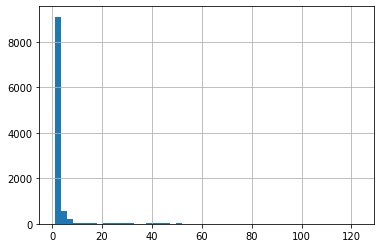

In [4]:
df["user_id"].value_counts().hist(bins = 50)

In [5]:
df_beer[df_beer.duplicated("id")]

,abv,ibu,id,name,style,ounces


In [6]:
print(f"Cervejas com ao menos uma compra {df['product_id'].unique().shape[0]}") 
print(f"Total de Cervejas cadastradas {df_beer.shape[0]}")
print(f"Usuários unicos {df['user_id'].value_counts().shape[0]}")
print(f"Total de compras feitas {df.shape[0]}")

Cervejas com ao menos uma compra 2409
Total de Cervejas cadastradas 2410
Usuários unicos 10256
Total de compras feitas 28144


In [7]:
most_bought_beer_id = df.product_id.value_counts().index.to_list()[0]
most_bought_beer = df_beer.loc[df_beer['id'] == most_bought_beer_id].iloc[0]["name"]

print(f"A cerveja mais comprada foi {most_bought_beer}")
print(f"Com {df['product_id'].value_counts().max()} compras")

A cerveja mais comprada foi People's Pilsner
Com 601 compras


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>


TOP N cerveja mais compradas

In [8]:
df_beer.name

0                   Pub Beer
1                Devil's Cup
2        Rise of the Phoenix
3                   Sinister
4              Sex and Candy
                ...         
2405               Belgorado
2406           Rail Yard Ale
2407         B3K Black Lager
2408     Silverback Pale Ale
2409    Rail Yard Ale (2009)
Name: name, Length: 2410, dtype: object

In [9]:
n = 10

ids = df.product_id.value_counts().head(n).index.to_list()
print(ids)

top_beers = [df_beer.loc[df_beer.id == i].iloc[0]['name'] for i in ids]

top_beers

[874, 1079, 424, 626, 296, 1399, 1096, 1098, 1986, 1871]


["People's Pilsner",
 'Seven Gates Pale Ale',
 'Rise of the Phoenix',
 'Fear of a Brett Planet',
 'Nonstop Hef Hop',
 "JP's Ould Sod Irish Red IPA",
 'Lemon Shandy Tripel',
 'Killer Whale Cream Ale',
 "Mountain Livin' Pale Ale",
 "Dale's Pale Ale (2003)"]

In [10]:
def get_top_beers_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top beers to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' beers ids 
    '''
    
    top_beers_ids = df.product_id.value_counts().head(n).index.to_list()
    
    return top_beers_ids 

def get_top_beers(n, df=df_beer):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    
    top_beers_ids = get_top_beers_ids(n)
    
    top_beers = [
        df_beer.loc[df_beer.id == i].iloc[0]['name'] 
        for i in top_beers_ids
    ]
    
    return top_beers

In [11]:
get_top_beers_ids(10)
get_top_beers(10)

["People's Pilsner",
 'Seven Gates Pale Ale',
 'Rise of the Phoenix',
 'Fear of a Brett Planet',
 'Nonstop Hef Hop',
 "JP's Ould Sod Irish Red IPA",
 'Lemon Shandy Tripel',
 'Killer Whale Cream Ale',
 "Mountain Livin' Pale Ale",
 "Dale's Pale Ale (2003)"]

Então caso um usuário seja novo na aplicação e não tenhamos um a triagem inicial, uma "boa" opção é a recomendação de uma das mais populares.

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


In [12]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with user_id, order_id, product_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and product ids on the columns with 1 values where a user puchase a beer
    and a 0 otherwise
    '''
    
    nan_matrix = df.groupby(['user_id', 'product_id'])['order_id'].count().unstack()
    user_item = nan_matrix.notnull().astype(int) 
    
    return user_item  


In [13]:
user_item = create_user_item_matrix(df)
print(user_item.shape)
user_item

(10256, 2409)


product_id,1,2,3,4,5,6,7,8,9,10,...,2400,2401,2402,2403,2404,2405,2406,2407,2408,2409
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by beers: 
                1's when a user has interacted with an beer, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    similarity = similarity.sort_values(ascending=False)
    # create list of just the ids
    most_similar_users = similarity.index.to_list()
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar

In [15]:
find_similar_users(171)[:10]

[934, 38, 175, 178, 45, 169, 96, 513, 235, 236]

In [16]:
def get_beer_names(beers_ids, df_beer=df_beer):
    '''
    INPUT:
    beers_ids - (list) a list of beer ids
    df_beer - (pandas dataframe) df as defined at the top of the notebook
    
    
    OUTPUT:
    beers_names - (list) a list of beers names associated with the list of beers ids 
                  (this is identified by the title column)
    '''
    
    beers_names = [df_beer.loc[df_beer.id == int(i)].iloc[0]["name"] for i in beers_ids]
    
    return beers_names 


def get_user_beers(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by beers: 
                1's when a user has interacted with an beer, 0 otherwise
    
    OUTPUT:
    beers_ids - (list) a list of the beer ids seen by the user
    beers_names - (list) a list of beer names associated with the list of beer ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the product_ids and beers names that have been seen by a user
    '''
    user_beers = user_item.loc[user_id]

    beers_ids = []
    for i, x in zip(user_beers.index, user_beers):
        if x:
            beers_ids.append(str(i))
            
    
    beer_names = get_beer_names(beers_ids)
    
    return beers_ids, beer_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds beers the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended beers starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    similar_users = find_similar_users(user_id)
    
    user_beer_ids, user_beer_names = get_user_beers(user_id)
    
    recs = []
    for user in similar_users:
        beer_ids, beer_names = get_user_beers(user)
        
        for i in beer_ids:
            if(i not in user_beer_ids and i not in recs):
                recs.append(i)
                if len(recs) >= m:
                    return recs
                
    return recs # return your recommendations for this user_id  

In [17]:
# Check Results
get_beer_names(user_user_recs(171, 10)) # Return 10 recommendations for user 171

['Misty Mountain Hop',
 'One-Hit Wonderful',
 'Alter Ego ',
 'Oktoberfest',
 'Straub Beer (Current)',
 'Lighthouse Amber',
 'Behemoth',
 'Pretzel Stout',
 "Devil's Cup",
 'Rise of the Phoenix']

## Apesar de termos recomendações precisamos melhorar a consistencia

* Diferente de escolher arbritrariamente, vamos escolher usuários com o maior numero de compras antes de escolher os de poucas compras.

* No lugar de escolhermos cervejas arbitrariamente de usuários onde o numero de recomendações começa abaixo de m e termina excedendo m, escolheremos cervejas que tem o maior numero de interações totais antes de escolher aquelas com menores iterações totais.

In [18]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by beers: 
            1's when a user has interacted with an beer, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of beers viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    similarity = user_item.dot(user_item.loc[user_id])
    

    neighbors_df = pd.DataFrame({"neighbor_id": similarity.index.to_list(), 
                                 "similarity": similarity.to_list(),
                                 "num_interactions": [user_item.loc[i].sum() for i in similarity.index.to_list()]
                                })
    neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending = [False, True], inplace=True)

    neighbors_df.drop(neighbors_df.index[neighbors_df['neighbor_id'] == user_id], inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by beer id
    rec_names - (list) a list of recommendations for the user by beer title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds beers the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total beer interactions 
    before choosing those with fewer beer interactions.

    * Choose beers with the beers with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    top_sorted_users = get_top_sorted_users(user_id)
    
    similar_users = find_similar_users(user_id)
    
    user_beer_ids, user_beer_names = get_user_beers(user_id)
    
    recs = []
    for user in similar_users:
        beer_ids, beer_names = get_user_beers(user)
        
        for i in beer_ids:
            if(i not in user_beer_ids and i not in recs):
                recs.append(i)
                if len(recs) >= m:       
                    return recs, get_beer_names(recs)
                 
    return recs, get_beer_names(recs)

In [19]:
rec_ids, rec_names = user_user_recs_2(171, 10)
print("The top 10 recommendations for user 171 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 171 are the following article names:")
print(rec_names)


The top 10 recommendations for user 171 are the following article ids:
['157', '158', '285', '307', '320', '335', '338', '420', '423', '424']

The top 10 recommendations for user 171 are the following article names:
['Misty Mountain Hop', 'One-Hit Wonderful', 'Alter Ego ', 'Oktoberfest', 'Straub Beer (Current)', 'Lighthouse Amber', 'Behemoth', 'Pretzel Stout', "Devil's Cup", 'Rise of the Phoenix']


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

In [20]:
def get_beers_frequent_styles(beer_ids, min_influency=.1 , df_beer=df_beer):
    
    beers = df_beer[df_beer.id.isin(list(map(int,beer_ids)))] # get consumed beers
    
    
    # GET recs by style
    # show styles that represents at least min_influency of all purchases
    top_styles = beers['style'].value_counts(normalize=True)[
        beers['style'].value_counts(normalize=True) >= min_influency
    ]
    
    user_top_styles = top_styles.index.to_list()
    
    return user_top_styles
    
def style_based_recs(user_id, m=10, df_beer=df_beer):
    '''
    Args:
        user_id (bool) - if true, make recs based on user
        m (int) - number of recommendations to give based on term
    Returns:
        recs (list) - list of beer ids that are recommended
        rec_names (list) - list of beer names that are recommended   
        
        
    Description:
        Recommened beers based on user most consumed beer styles
    '''
    
    beer_ids, _ = get_user_beers(user_id)  
    
    user_top_styles = get_beers_frequent_styles(beer_ids)
    
    
    top_beers_ids = get_top_beers_ids(df_beer.shape[0])
    
    prefered_styles_beer = df_beer.loc[df_beer['style'].isin(user_top_styles)]
        
    top_recommendation_by_style = []
    
    
    #Map beers id to int to use in for if's
    beer_ids = map(int, beer_ids)
    for i in top_beers_ids:
        if len(top_recommendation_by_style) > m: break
            
        if (i in prefered_styles_beer['id'].values and i not in beer_ids):
            top_recommendation_by_style.append(i)
            

    rec_names = get_beer_names(top_recommendation_by_style)
    
    return top_recommendation_by_style, rec_names
    
    

In [21]:
# make recommendations for a brand new user
ids, names = style_based_recs(172, m = 10)

print(ids)
print(names)

# make a recommendations for a user who only has interacted with article id '1427.0'

#make_content_recs([1], user_id=False)

[1079, 424, 626, 1399, 1986, 1871, 1395, 865, 1947, 1976, 678]
['Seven Gates Pale Ale', 'Rise of the Phoenix', 'Fear of a Brett Planet', "JP's Ould Sod Irish Red IPA", "Mountain Livin' Pale Ale", "Dale's Pale Ale (2003)", '5 Day IPA', 'Java the Hop', 'Indie Pale Ale', 'Desert Magic IPA', 'Fistful Of Hops Blue']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

Unsupervisioned learning

In [22]:
user_item

product_id,1,2,3,4,5,6,7,8,9,10,...,2400,2401,2402,2403,2404,2405,2406,2407,2408,2409
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
u, s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices

s.shape, u.shape, vt.shape

((2409,), (10256, 10256), (2409, 2409))

As we dont have missing value on our matrix, we can use SVD instead of FunkSVD

In [44]:
df_train = df.head(20000)
df_test = df.tail(8144)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_beers - all of the test beers ids
    
    '''
    # Your code here
    
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(df_test["user_id"].unique())
    
    test_beer = list(df_test["product_id"].unique())
    
    return user_item_train, user_item_test, test_idx, test_beer


In [45]:
user_item_train, user_item_test, test_idx, test_beer = create_test_and_train_user_item(df_train, df_test)

user_item_train.shape, user_item_test.shape, len(test_idx), len(test_beer)

((8728, 2065), (2325, 1205), 2325, 1205)

In [46]:
# users that we can make prediction
len(np.intersect1d(list(df_train['user_id'].unique()), test_idx))

797

In [47]:
# users that we can't make prediction
len(test_idx) - len(np.intersect1d(list(df_train['user_id'].unique()), test_idx))

1528

In [48]:
#Beers that we can made predictions
len(np.intersect1d(list(df_train['product_id'].unique()), test_beer))

861

In [49]:
#Beers that we cant made predictions
len(test_beer) - len(np.intersect1d(list(df_train['product_id'].unique()), test_beer))

344

In [50]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train =  np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

s_train.shape, u_train.shape, vt_train.shape

((2065,), (8728, 8728), (2065, 2065))

In [51]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
train_idx = list(df_train['user_id'].unique())
train_beers = list(df_train['product_id'].unique())

intersect_users = np.intersect1d(train_idx, test_idx) 
intersect_beers = np.intersect1d(train_beers, test_beer)


# Get new matrix idx for intersect users and articles

new_train_idx = np.where(np.in1d(train_idx, intersect_users))[0]
new_train_beers = np.where(np.in1d(train_beers, intersect_beers))[0]

new_test_idx = np.where(np.in1d(test_idx, intersect_users))[0]
new_test_beers = np.where(np.in1d(test_beer, intersect_beers))[0]

In [52]:
user_item_test.shape

(2325, 1205)

In [53]:
#Mout new train and test matrix using only interct values

test_set = user_item_test.iloc[new_test_idx,new_test_beers]
train_set = user_item_train.iloc[new_train_idx, new_train_beers]


print(train_set.shape)
test_set.shape

(797, 861)


(797, 861)

In [54]:
latent_features = np.arange(1,601,5)
err = []

for k in latent_features:

    # Update shape of u, s and vt for train matrix
    s_train_k = np.zeros((k, k))
    s_train_k[:k, :k] = np.diag(s_train[:k])

    u_train_k = u_train[:, :k]
    vt_train_k =  vt_train[:k, :]
    
    # Update shape of u, s and vt for test matrix 
    s_test_k = s_train_k

    u_test_k = u_train_k[new_train_idx,:]
    vt_test_k =  vt_train_k[:,new_train_beers]
    
    # Compute the dot product
    pred_ratings = np.dot(np.dot(u_test_k, s_test_k), vt_test_k)

    # Compute the squared error for each predicted vs. actual rating
    sum_square_errs = np.sum(np.sum((test_set - pred_ratings)**2))
    
    err.append(sum_square_errs)

test_set.shape

(797, 861)

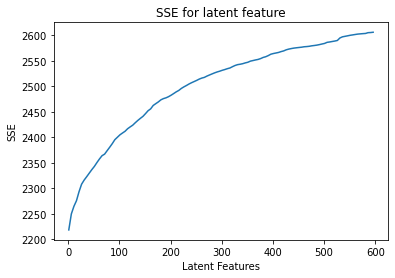

In [55]:
plt.plot(latent_features, err)
plt.title('SSE for latent feature')
plt.xlabel('Latent Features')
plt.ylabel('SSE')
plt.show()

Pontos de atenção:
-> Usuário consumir um produto uma vez, ou 100 vezes tem o mesmo peso para o modelo